### Training Contextual Bandits through (Full) Batch Method, Logistic Regression Cls Learner, default hyperparams

In [1]:

import os
import re
import sys
import json
import time
#import config
import spotipy
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

In [2]:
import pandas as pd
import glob
import os

path = r'new data/training_set' # use your path

In [3]:
import pickle
#df_cd.to_pickle("new data/full_dataset.pkl")
full_data = pd.read_pickle("new data/full_dataset.pkl")

In [4]:
full_data = full_data.drop(columns=['session_position'])

In [5]:
full_data.head()

,session_id,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
2,62_03d8ebcd-e5e1-41a0-966b-258d296d8af7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,1,1,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
3,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
4,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   track_id                       object 
 2   context_switch                 int64  
 3   no_pause_before_play           int64  
 4   short_pause_before_play        int64  
 5   long_pause_before_play         int64  
 6   hist_user_behavior_n_seekfwd   int64  
 7   hist_user_behavior_n_seekback  int64  
 8   hist_user_behavior_is_shuffle  int32  
 9   premium                        int32  
 10  skipped                        int32  
 11  duration                       float64
 12  release_year                   int64  
 13  us_popularity_estimate         float64
 14  acousticness                   float64
 15  beat_strength                  float64
 16  bounciness                     float64
 17  danceability                   float64
 18  

In [7]:
# remove ratings of tracks with < N plays. too few plays will cause the recsys to get stuck in offline evaluation

In [8]:
def preprocess_tracks(df, min_number_of_plays=5000):
        # remove ratings of movies with < N plays
        tracks_to_keep = pd.DataFrame(df.track_id.value_counts()).loc[pd.DataFrame(df.track_id.value_counts())['track_id']>=min_number_of_plays].index
        df = df.loc[df['track_id'].isin(tracks_to_keep)]
        return df

In [9]:
data_preprocessed =  preprocess_tracks(full_data, min_number_of_plays=5000)
print(len(data_preprocessed))

1535450


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

y = np.array(data_preprocessed.skipped)
X=np.array(data_preprocessed .drop(
    columns=["skipped","session_id","track_id"], axis=1
))
print (y.shape)
#scaled_data = StandardScaler().fit_transform(X); scalling data does not improve learner's (predictive model) perfomance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.994, random_state=42, stratify=y)
print (y_train.shape)

(1535450,)
(9212,)


In [11]:
y_train.shape[0]

9212

In [12]:
# checking is classes are balanced
counts = np.unique(y_train, return_counts=True)
counts

(array([0, 1]), array([4857, 4355], dtype=int64))

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
X_train = StandardScaler().fit_transform(X_train) 

In [15]:
nchoices = y_train.shape[0]

In [16]:
nchoices

9212

Batch Evaluation

In [17]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS,  SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y_train.shape[0]
base_algorithm = LogisticRegression(solver='chol', warm_start=True)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior = 'auto', percentile = 80)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior = 'auto')
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                      beta_prior = 'auto')
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = 'auto')
    #logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,\n",
                              # beta_prior = beta_prior_ts, random_state = 5555)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                         decay_type='threshold',
                                        beta_prior = 'auto')
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                          decay_type='percentile', decay=0.9997,
                                          beta_prior='auto')
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                                 explore_rounds=1500, beta_prior=None)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior='auto')
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                            active_choice='weighted', decay_type='percentile', decay=0.9997,
                                            beta_prior='auto')
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior='auto')
    
models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer, adaptive_active_greedy, softmax_explorer]

In [18]:
 # These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft = [list() for i in range(len(models))]
lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr,  rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft]
# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X_train[:batch_size, :]
np.random.seed(1)
y_train = np.reshape(y_train, (-1, 1))
action_chosen = np.random.randint(nchoices, size=batch_size)
print(action_chosen)

rewards_received = []
for action in action_chosen:
    rewards_received.append(int(y_train[action]))
print(rewards_received)

# fitting models for the first time, on random context X and its corresponding rewards
for model in models:
     model.fit(X=first_batch, a=action_chosen, r=np.array(rewards_received))
        
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr,lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr, lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    print(actions_this_batch)
  
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    print(new_actions_hist)
    rewards_batch = []
    for action in actions_this_batch:
        rewards_batch.append(int(y_global[action]))
        
    # keeping track of the sum of rewards received   
    rewards.append(sum(rewards_batch))
    
    # refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    print(len(X_global[:batch_end, :]))
    print(len(new_actions_hist))
    
    new_rewards_hist = []
    for action in new_actions_hist:
        new_rewards_hist.append(int(y_global[action]))
    model.fit(X_global[:batch_end, :], new_actions_hist, np.array(new_rewards_hist))  #  y_global[:batch_end, :] np.array(rewards_batch

    return new_actions_hist

# running all the simulation\n",
for i in range(int(np.floor(X_train.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_train.shape[0]])

    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                                 lst_rewards[model],
                                                 lst_actions[model],
                                                 X_train, y_train,
                                                 batch_st, batch_end)

[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
[ 76 170 146 129 254   3 116 190 207  95 236  83 226 178  20 252 186  71
 162  48 188 205 193 177 129  60  13  58  53 199 129 164  17 133 208 216
   8 116 154 177 160 126  65  19 147  61  73 208 139 236]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13

[106  92  39 214  97 148  16 145  17 202 172  70 162  59 177 232 155 247
 171 186  96  93  42  57 153 110  46 103  62 131 109   8  45  17 200 128
 146 162 196 224 148 138 134 189   5 114  54  25 208 206]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  189  214  148  143   93  147
   90   56   19  164  179  172   51   94  211  180   83   71   19   16
  204  159  162  255   28   63  222  239  212   25   82  224  239  129
  204   98  204  246   41   10  151    7  158   60  237   36  108  162
   24  140  106   92   39  214   97  148   16  145   17  202  172   70
  162   59  177  232  155  247  171  186   96   93   42   57  153  110
   46  103   62  131  109    8   45   17  200  128  146  162  196  224
  148  138  134  189    5  114   54   25  208  206]
150
150
[173 229 168 224 112  78 1

[186  91  26  51 250 105 243 209 178 159 208 133  75  98   5  45 155 215
 222 244  44 188 154  11 209 115 245  20 239  28 227 145 231 223  74   8
  83  22 180 130   1 152 153  15  16 110  15  52 183 139]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[123 236 205 135  59  20  74 122 180 208 133  17 122 168  96 168  63 253
 234 200 204 173 192  70 158 152 179 131 124 111  59 131 150 241 179 217
 150  58 163 195 161  69 186  41   6  96  81 217 202 188]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  225  190   65  181  252  188
  143   37  218  206   20  105  198   32   40  188   92  179    2  227
  215  217  156  190   72   65  193  198   36   30  183  198  147   50
  150  222  191  188  196   64  156  215   26  231   34  168  196  101
   82  118  233  103  170   13   30   50  231  246   20  215   82    1
  201   37  150  235  179  174  107   64  159  233  114   60  237  245
  152  211  154   59    7  168   78  160  249  108   40  100  152  208
   39   80   60  228  116  206  156  236  149   53  123  236  205  135
   59   20   74

[ 15  15 141 156  20 109 156  15 156 234  20  15 156 156 109 156 156 156
  15 156 156 156 156 156 156 156 156 156 156 156 156 156  15 156  15 156
 156 156  20 156  20  20 156 156 156  20 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[221 145 133 101 210 214 132 132 182 133   8   5 133 252  81 186 197 153
 139  15 139 158 247   1 139 145 138  26 190 242  60 163 159  94 188 115
 123 168 238 151 245 145 255 133  19  15  13 127 253  26]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[ 15  15  15  15  15 141  15  15  15  15  20  15  15  15 109  15  15  15
  15  15  15  15  15  15  15  15  15  15 109  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   76  115  141  129
  129  115  109   76  216  109  216  208  175  175  233   50   26  215
  141  252   15   50   22   26   15   76   71   71  196   76  234  216
  196  252   20   22  234  216    1   20   76  175  234   15   76  175
  234  109   50  216  109  141   50   20  109  241  109   15  109   15
  109   15  241  129  129  109   50   20   20   15  141  241  115  141
  141  241   15   15   15   22  141   71   15  109  234  234  215  234
   15  196   15  169   15  234   71   76   20  141   15   15   15   15
   50   15   15

[ 15  67  34 141 229  63 239  66 145 168  15 226 201 125 200 239 161  76
 215 143 186 139  22 195 139  20 192 149 111 168 116 145  15  60 245 145
 140 222 210 182 198  17 139 145   0  86  45  58 145 245]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15 141
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   76  115  141  129
  129  115  109   76  216  109  216  208  175  175  233   50   26  215
  141  252   15   50   22   26   15   76   71   71  196   76  234  216
  196  252   20   22  234  216    1   20   76  175  234   15   76  175
  234  109   50  216  109  141   50   20  109  241  109   15  109   15
  109   15  241  129  129  109   50   20   20   15  141  241  115  141
  141  241   15   15   15   22  141   71   15  109  234  234  215  234
   15  196   15  169   15  234   71   76   20  141   15   15   15   15
   50   15   15

[145 145 139 145 145 241  15  15 145 145 139 116 145  49  78 145  53 145
  32  15  68 139  17 102 199  17 145 145 139  45 245  28 145  69 145 126
 242 145  15 139 139 245 152 145 116 145 238 145 145 144]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156  20 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156  20
 156  20 156 156 156 156 156  20 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[108 108 108 108 108  58 181 108 168  45 108 168 108 216 108 108 108 113
 168 108  58 108  58 108 108 247 108 108  58 108 112  45 108 104 108 108
 168 247  37 170 108 108 108 116 168  37  58 108  58  18]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[168 108 193 208  18 160 216 184  83  56 193 203  90 134  52  77 227 220
  75 235 123  83 194  92  24 185 100  70 133 236  83  41 235  71 148  58
  56 155 186 221 174 141 148 220 242 130 234 190 196 155]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[145 145 145 145 145 145 145 145 145 145 145 145 145 145  72 139 145 145
 145 145 145  15 145 145 145 145 139 145 145 100 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[156 156 156 163 156 156 163 112 156 163 125 156 156 156 231 156 156 163
 156 156  69 156 156 156 239 156 163 156 173 156 156 163 156 156 163 163
 156 156 156 156 156 214 163 156 156 156 156 136 156 163]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   72  167  205  159  133  115
  143   96   90   58  101  200   85  239  178  156  138  163  216   31
   85  105  246  172  218    2  106   50  147   33  204  120   33   11
  238  148    2  198  128  183   74  179   69    2  231  124  162  175
   88  246   20  148  242  117  132   82  159   78  124  163  255   29
   53   67  133   79   37  189    6  167  213   90   91   18  104   51
  235  206   23   55   74  161  199  241  190  156  232   51  149  182
  156  232  231   66  243    4  231   60   33  174  104   71  231  222
  101  250   81

[ 34 208 113 209  80 149 159 197 132  88  23 173 166 193 112  24 243 205
  29 206 245 247 116 214 132   2 132 145  70 227  48 133  85 176 154 217
 127   4 142 113  84 182 132 152  56  30 177 219 121  64]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[224 158  41 184 238 131   3 117  88 186 252  28  86  82 230  12 132   7
  76  45 141  82 222 204  96 202  64 104 215  80 237  77 108  16 124  93
 158  36 187  61 212 173  35  20  45  49  74  42 224  71]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  175   75  135   29   26   82
  143   79  151   42  100  246  117  232   88   53  118   56   63  150
   39  136   71  217  210  151  241  247  127  120  215   34   93  204
  182   90  199  163  248   98  214  134  154   49  103  222  148  151
   27  184  151  240  215  218  143  152  154   56  190  216  219  155
   23   52  107  109  190  171   55    1   39   46   59  180  152  168
  119   86  150  247   45  250  215   49   92    9  105  240   57   52
  133  252   14  194   33  234   28   23   72  186  135  227    3   76
   64  217  100

[ 58 108 108 108 108 108 108 108 108  58 108 108 108 108 108  58 108 108
 108 108 108 108 108 108 108 108 168 108 108 108 108 108 247 108 108 108
 108  58  58 247  58 108 108 108 168  58 108 108 108 168]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   76  115  141  129
  129  115  109   76  216  109  216  208  175  175  233   50   26  215
  141  252   15   50   22   26   15   76   71   71  196   76  234  216
  196  252   20   22  234  216    1   20   76  175  234   15   76  175
  234  109   50  216  109  141   50   20  109  241  109   15  109   15
  109   15  241  129  129  109   50   20   20   15  141  241  115  141
  141  241   15   15   15   22  141   71   15  109  234  234  215  234
   15  196   15  169   15  234   71   76   20  141   15   15   15   15
   50   15   15   15   15   15   15  196   15   15   15   15  109

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  189  214  148  143   93  147
   90   56   19  164  179  172   51   94  211  180   83   71   19   16
  204  159  162  255   28   63  222  239  212   25   82  224  239  129
  204   98  204  246   41   10  151    7  158   60  237   36  108  162
   24  140  106   92   39  214   97  148   16  145   17  202  172   70
  162   59  177  232  155  247  171  186   96   93   42   57  153  110
   46  103   62  131  109    8   45   17  200  128  146  162  196  224
  148  138  134  189    5  114   54   25  208  206  247   17  160  210
   93   50    1

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[ 20  50  20  20  50  20  20  20  50 242  50  20 150 150  20  50  20 188
 150  20  50  20  20 190  20  20 234  20  50  20  20  20 152  20  20  50
  20  20  20  20 150 150  50  50 217  50  20  20 221  50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  225  190   65  181  252  188
  143   37  218  206   20  105  198   32   40  188   92  179    2  227
  215  217  156  190   72   65  193  198   36   30  183  198  147   50
  150  222  191  188  196   64  156  215   26  231   34  168  196  101
   82  118  233  103  170   13   30   50  231  246   20  215   82    1
  201   37  150  235  179  174  107   64  159  233  114   60  237  245
  152  211  154   59    7  168   78  160  249  108   40  100  152  208
   39   80   60  228  116  206  156  236  149   53  123  236  205  135
   59   20   74

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[156 156 252 156  34 156 208 156 156 125 156  59 163 156 163 156 156 156
 210 156 156 156 156 156 156 156 163 156 156 156 163 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 209 156 156 163]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   72  167  205  159  133  115
  143   96   90   58  101  200   85  239  178  156  138  163  216   31
   85  105  246  172  218    2  106   50  147   33  204  120   33   11
  238  148    2  198  128  183   74  179   69    2  231  124  162  175
   88  246   20  148  242  117  132   82  159   78  124  163  255   29
   53   67  133   79   37  189    6  167  213   90   91   18  104   51
  235  206   23   55   74  161  199  241  190  156  232   51  149  182
  156  232  231   66  243    4  231   60   33  174  104   71  231  222
  101  250   81

[202 114  81 233 128 211 103 142 148 147 196 205 248  24 221 246 251  46
   8 157  14 118  23 140 202  97  24  78 119  26   7  24 162 107  61 156
 129  51 126 130  73 155  15  65 160  86 137   1  14 113]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[175  39 253 180  98 197 180  88 219 114 143 136  38  93  86 211  61 123
  27 212  70 254 249 231 152  89 120 152  95 167   6 231  27  52 151 104
  61  56 176  88 141 117 212 138 247  41 150 124 210  59]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  175   75  135   29   26   82
  143   79  151   42  100  246  117  232   88   53  118   56   63  150
   39  136   71  217  210  151  241  247  127  120  215   34   93  204
  182   90  199  163  248   98  214  134  154   49  103  222  148  151
   27  184  151  240  215  218  143  152  154   56  190  216  219  155
   23   52  107  109  190  171   55    1   39   46   59  180  152  168
  119   86  150  247   45  250  215   49   92    9  105  240   57   52
  133  252   14  194   33  234   28   23   72  186  135  227    3   76
   64  217  100

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108  58 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   76  115  141  129
  129  115  109   76  216  109  216  208  175  175  233   50   26  215
  141  252   15   50   22   26   15   76   71   71  196   76  234  216
  196  252   20   22  234  216    1   20   76  175  234   15   76  175
  234  109   50  216  109  141   50   20  109  241  109   15  109   15
  109   15  241  129  129  109   50   20   20   15  141  241  115  141
  141  241   15   15   15   22  141   71   15  109  234  234  215  234
   15  196   15  169   15  234   71   76   20  141   15   15   15   15
   50   15   15   15   15   15   15  196   15   15   15   15  109

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  189  214  148  143   93  147
   90   56   19  164  179  172   51   94  211  180   83   71   19   16
  204  159  162  255   28   63  222  239  212   25   82  224  239  129
  204   98  204  246   41   10  151    7  158   60  237   36  108  162
   24  140  106   92   39  214   97  148   16  145   17  202  172   70
  162   59  177  232  155  247  171  186   96   93   42   57  153  110
   46  103   62  131  109    8   45   17  200  128  146  162  196  224
  148  138  134  189    5  114   54   25  208  206  247   17  160  210
   93   50    1

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[ 50  20  20  20 109 150 219  20  20 150  50  20  20  20  20  20  50  20
 179  20  20  20  20 150 156  50  20  50  20  20  20  50  20  20  50  20
  20  50  50  50  20 109  20  20  20  50 116  20  20  50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  225  190   65  181  252  188
  143   37  218  206   20  105  198   32   40  188   92  179    2  227
  215  217  156  190   72   65  193  198   36   30  183  198  147   50
  150  222  191  188  196   64  156  215   26  231   34  168  196  101
   82  118  233  103  170   13   30   50  231  246   20  215   82    1
  201   37  150  235  179  174  107   64  159  233  114   60  237  245
  152  211  154   59    7  168   78  160  249  108   40  100  152  208
   39   80   60  228  116  206  156  236  149   53  123  236  205  135
   59   20   74

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[249 123  79 193  58 130 171 251 107  13 220 191 212   7 166 149 120  69
 130 212  50  56 249 130 173 118 147 189   4 233 102   3 123 182 144 197
  74 225  58  37  65 217 249 225 132 113  10 200  62 168]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[ 58 167 238  25 188  21 170 186 251 254 205  42 138 228 162 245 174 196
 137  73  81 101 182 190  22 161 153  23  33  44 233 186 188  67  61 192
  99 185 238 241 179  70 241 122 251  43 174 107 206  11]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[133 244  82  77 135  32  35 181   6 128  48  97 114  42 253 206 195 200
  40 233 136 168 205 151 240 220 160  89 216  78  69 180 251 234 159  44
  65 132 216 210 124 162 222 184 215  29 246  63  43 240]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108  58 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[ 34 182  86  37 202  58 206  65  19 222 205 246 252 243 206 129 143   0
  11 103 147 252  20  57 177  79  10 198 244  65  30  56  58 254  85  83
 235   2 113  75 141 141 135  57  42 111  38 217   6  17]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   76  170  146  129  254    3
  116  190  207   95  236   83  226  178   20  252  186   71  162   48
  188  205  193  177  129   60   13   58   53  199  129  164   17  133
  208  216    8  116  154  177  160  126   65   19  147   61   73  208
  139  236  214   49  168   96  150  235   49  136  239   74  117  177
  225  173    8  101   50  221  123   43  199   37  228  242  218  251
   50   88  223   67   45  196  116  191   58  233  122  145  122  245
  244  198  189  152   25  196  145  143  123   29  186   91   26   51
  250  105  243

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   54   71    6   58   71  213
  212  110  197  221   17  118  162   57  113    3   37   40  142  148
  155  164  214   45  182  164  155   84   88  164   50   22  149  114
  221    3  163   95  191  101   69   19   27  107  108   26  217  217
  216  156  173  229  168  224  112   78  157   98  217  225  210  193
  207  221   67  176  231  240   34  162  165  241  168  108  206  129
   88   76   27    1  134  181  191  127   45  234   58  161  127   25
   25  218  206   42  235  160  227   85  186  197   97   45  166   90
  108  224  170

[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  141  234  196  196  234  252
   20   22  175  241   22  129  156  156   50  198   71  215  241  252
  196   26   71  196  233  196  234  109  129  252  196  233   20  156
  109  141  198   50   71  241  196  196  233   20  196  196  175  156
   15   71  156  141   15   20  175   50  156  129  156  115  156  233
   50   20   15   22  252   20  175  156  156   20   15  156  109   20
  109   20   50  109   20  156  234   20  141  156  253  141  252   20
  156  156   15  141  196   15  198  234  141   20  156  156  156   20
   20   50   20

[188 251  28 123  22  16  23 113 127 135  88  37  16 231 129  33 152 186
 221 169 244 130 192  69  14  37 206 179  85 116 167  98  35 198  80 155
 110 227 168 196 202 173 250 215 104  84 203 203 188  62]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  231   27  107  122  147  254
   15   16   24  103  203  174  140  155  223  252   97  157   62   58
   65  142  173   17  129  163  118  143  254  139  157   38  197   17
   88  112  135  124  118   48  152   13  165    6  195  105   50   71
  202  226  121   66   94   52   50    2    8  234  220  187   69   91
    9  130   56    2   56   13  137   48    5   79   71   92   13  252
   34  223    4  204  196  195  166  252   89  165  228   12  155  137
   40   44  172  121  142   53   57   53   63  211   15   50  138  233
  130  129  171

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046    3   20  234  129  141  196
  233  115  198    8   76  196   50  241  129   26   22  196   15   20
   20   76  129  156  129   76  241   71  252   22   22   22  196  129
   69  241   76  134  216  241  196  141   72  156  252  216   20  198
  215   26  156   20   15   22  156   72   20  156   69  156   15  241
  215   50  141   20   50   20  215  196  168   71   50   26   72  241
   76  129  196  141   15  115  141   20   72   20   72   20  234   76
   20  216   20   20   69   15  215   20   20  141  141   20   15   20
   20   20   20   20  141   20  141   20  141   20  141  184   20

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
1050
1050
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
1050
1050
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
1050
1050
[156 246 156 156 156 156 164 156 156 156 156 156 156 163 156 156 156 156
 156 156 156 156 156 156 156 156 110 156 156 156 219 156 156 156 156 156
 156 156 156 156 238 156 156 156 156 196  66 156  92 156]
[ 235 5192  905 ...  156   92  156]
1050
1050


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
1200
1200
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
1200
1200
[222 188  10 169  22 132  90  25 205 109   4  19  57 221 107 240 159 159
  16  48  99 176 177  93 245 218 225 151 170 102 153  18  61 118  86 143
  33   1 245 185 253 121  99 253  41  39  45 204  76 170]
[ 235 5192  905 ...  204   76  170]
1200
1200
[ 20  20  20  20  20  28  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20 217  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20 251  20  20  20  20  36]
[ 235 5192  905 ...   20   20   36]
1200
1200
[141  20  20  20  50  20  20  20  20  20  20  20  

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 72 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
1350
1350
[ 27  49  33  45 151 238 158 247   6 216 168  86 224   5  79 104 150 242
  58 104 151 179 223 138 242  69  38  24 232 150   7 122 227 247 104  80
 227  77 184 145 144 136 134  20 172   7 220 229 153 115]
[ 235 5192  905 ...  229  153  115]
1350
1350
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
1400
1400
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
1400
1400
[108 108 108 108 108 108 108 108 108 108 108 108 1

[242 156 156 156  76 156 156 156 156 156 156  94 156 241 156 156 156 156
 156 156 118 156 156 156 156 156 240 156 156 156 128 156 156 236 156 156
 156 156 156 156 156 156 156 226 156 156 110 156 156 156]
[ 235 5192  905 ...  156  156  156]
1550
1550
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
1550
1550
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
1550
1550
[ 99 194  63  54 227 103 230 179 235  64 157  60 222  14 174 255 249 103
 151 253 249  25 234  20 115 213  83 252 156 102  21  67  78 185 141 160
   4  30 121  92 114 240 207 125 219 195 189 225 138  93]
[ 235 5192  905 ...  225  138   93]
1550
1550
[50 20 20 50 20 20 20 20 20 20 20 20 20 20 20 20 2

[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20 156  20
  20  20  20  20  20 156  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20 234  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
1700
1700
[ 31 176 151 209 104 170 109 254  52  79  58  27 152 249 232  13  12 151
 145  38 127 224 205 227 224 150 227  49  49 227  86 224 242 100 212 145
  49 151  37  46 150  49 151 247  27 247 239 151  49 152]
[ 235 5192  905 ...  151   49  152]
1700
1700
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
1750
1750
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
1750
1750


[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
1900
1900
[156 156 156 156 156 156 156 156 156 217 156 156 156 156 156 156 156 156
 156 156 156 156 156 156  58 156 156 156 156  52 156 156 156 156 156 156
 156 156  46  15 156 156 156 111 156 156 156 156  14 156]
[ 235 5192  905 ...  156   14  156]
1900
1900
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
1900
1900
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15 171  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
1900
1900


[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
2050
2050
[224 153 224   7 150 151  38  20 151 150 249 238 104 151  15 207 224 212
 150 151  49 127 150 151 223 151  79 151 227 224 118 150 155  49 151  49
 224 150 118  49  89 151  86  86   7 104  49  98 176 150]
[ 235 5192  905 ...   98  176  150]
2050
2050
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
2100
2100
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
2100
2100
[108 108 108 108 108 108 108 108 108 108 108 108 1

[156 156 242 156 156 177 156 156  19 156 156 156 156 156 156 156 156 156
 156 156   7 156 156 156 156 156 156 156 156 107 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
2250
2250
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
2250
2250
[ 15  15  18  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15 134  15  15  15  15  15  15  15  15  15  15  15  15  15  15 191  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
2250
2250
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2250
2250
[ 20  20  20  20  20  20  20  20 187  20  20 178  20  20  20  20  20  20
  20  20  20  20  20  20  20

[ 20  20  20  20  20  20  20  20  20  20  20  20 156  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2400
2400
[ 49 151  27 247 224  27  49 151 224 245 151 151 224 247 229 152 151  46
 232 151 150  49  49 232  49  69 151 151  45 151 224 104 104  98  49 151
 151 151 104  89  49 151 224  49 224 151  49 117 151 151]
[ 235 5192  905 ...  117  151  151]
2400
2400
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
2450
2450
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
2450
2450


[156 156 156 156 156 156 156  10 156 156 164  13 156 156 156 156 156 156
 156 156 156 156 246 156 156 156  69 156 156 156 156 149 161 192 156 156
 156 156 156 156 211 156 156 198 156 156 196 136 175 156]
[ 235 5192  905 ...  136  175  156]
2600
2600
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
2600
2600
[ 15  15  15  15  15  15  15 239  53 109  15 114  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15   3  15]
[ 235 5192  905 ...   15    3   15]
2600
2600
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2600
2600
[ 20  20  20  20  20  50  20  20  20  20  20  20 179  20  20  20 116  20
  20 179  20  20  20  20  20

[ 49 151 151 151  89 151 224 150 150 151  49 151 151  49 151 247 151 224
 151 151 151 151 247 151 151 151 150 150 104  49 151 151 151 151  49 224
 151 150  49 227 151 150 151 150 151 151 232 104 224 150]
[ 235 5192  905 ...  104  224  150]
2750
2750
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
2800
2800
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
2800
2800
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
2800
2800


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
2950
2950
[ 15  15  15  15  15 155  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15 157  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
2950
2950
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2950
2950
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  66  20  20 131  20  20  20  20  20
  20  20  58  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2950
2950
[ 20  20  20  20  20  20  20  20  20  20 141  20  20  20  20  20  20  20
  20  20  20  20  20  20  20

[151 151 247  49 151  49 151 151 150 151  49 151  49 151  49  49  49 151
 151 151 151 151 151 151  49 151 151 150 151 151 224 151 151 151 151  49
 151 151  49 151 224 151  27  49 151 151  49 150 224 151]
[ 235 5192  905 ...  150  224  151]
3100
3100
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
3150
3150
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
3150
3150
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
3150
3150


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
3300
3300
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 22 15 15 15 15 15 15 15 15 15 15 15 18 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
3300
3300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3300
3300
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 47 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
3300
3300
[ 20  20  20  20  20  20  20  20  20  20  20  20 156  20  20 141  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20 141  20  20  20
  20  20  20  20  20  20 196  20  20  20  20  20  20  2

[151  49 151 151 151 151  49  49 151 151 151 151 151 151 151 151 151 151
 151  49 151 151 151 151 151 151 151 151 151  49 227 151 151 151 151 151
  49  49 151  49 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
3450
3450
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
3500
3500
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
3500
3500
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
3500
3500


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
3650
3650
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  65  15  15  15  15 213
  15  15  47  15  15  15  15  15  15  91  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
3650
3650
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3650
3650
[ 20  20 188  20  20  20  20  20  20  20  31  20  20  20  20  20  20  20
 152  20  20  20  20  20  20  20  20  20  20  20  20 150  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
3650
3650
[ 20  20  20  20  20  20  20  20  50  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20

[151 151 151 151 151 151 151  49  49 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150
 151 151 151 151 151 151 151  49 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
3800
3800
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
3850
3850
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
3850
3850
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
3850
3850


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
4000
4000
[ 15  15  15  15  15  15  15  15  15  15  15  15  91  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15   0 226  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
4000
4000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4000
4000
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
 152  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  34  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
4000
4000
[ 20  20  20  72  20  20  20  15  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20

[151 151 151 151 151 150 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 224 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
4150
4150
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
4200
4200
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
4200
4200
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
4200
4200


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
4350
4350
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 58 15 15 15 15 15 40 15 15 15 15 15 15 15 15 15 78 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4350
4350
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4350
4350
[ 20  20  20  20  20  20  20  20  20 217  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
4350
4350
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 72 20 20 20 20 20 20 20 20 20 20
 20 2

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
4550
4550
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
4550
4550
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
4550
4550
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156  28 156
 156 156 156 156 156 156 156 156 156 156 205 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 230  25 156 156 156]
[ 235 5192  905 ...  156  156  156]
4550
4550


[ 15  15  15 190  15  15  15  15  15 107  15  15  15  15  15  15  15  15
  15  15 167  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
4700
4700
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4700
4700
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
4700
4700
[20 20 20 20 20 20 20 20 69 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 50 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
4700
4700
[151 151 151 151 151 151 151 151 151 151 151 151 151 104 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 15

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
4900
4900
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
4900
4900
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
4900
4900
[156 156 156 156 156 156  59 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 135 156  51 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 202 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
4900
4900


[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15 120  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15 142  15  15  15]
[ 235 5192  905 ...   15   15   15]
5050
5050
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5050
5050
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20 168  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
5050
5050
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 15 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
5050
5050
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 

[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
5250
5250
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
5250
5250
[156 156 156 156 226 156 156 156 156 156 156 156 156 156 156 156 156 156
 185 156 156 156 156 156 156  27 156  79 156 156 231  93 156 156 156 156
 156  65 156 156 156 212 156 156 213 156  40 156 156 156]
[ 235 5192  905 ...  156  156  156]
5250
5250
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
5250
5250


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5400
5400
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
5400
5400
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 69 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
5400
5400
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151  49 151 151 151 151  49 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
5400
5400
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 14

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
5600
5600
[156 156  68 156 156 156 156 156 156 156 156 156 156  24 156  30 156 156
 156 156 156 156 156 156 156 241 156 156 156 156 156 135 238 156 156 156
 156 156 156 156 156 156  43 156 156 156 156 156 111 156]
[ 235 5192  905 ...  156  111  156]
5600
5600
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
5600
5600
[ 15  15  15  15  15  15  15  15  15  15  15 194  15   5  15  15  15  15
  15  15  15   4  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  33  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
5600
5600


[20 50 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 33 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 37 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
5750
5750
[ 20  20  20  20  20  20  20  20  20  20  20  20  20 141  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
5750
5750
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
5750
5750
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
5800
5800
[162 162 162 162 162 162 162 162 162 162 162 162 1

[156 156  34 156 156 156 156 156 156 156 108 156 156 156 156 156 181 253
 156 156 156 156 156 156 156 156 156 156 140 156 156 156 156 156 120 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 110]
[ 235 5192  905 ...  156  156  110]
5950
5950
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
5950
5950
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15 174  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
5950
5950
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5950
5950
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 

[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
6100
6100
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
6150
6150
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
6150
6150
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
6150
6150


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
6300
6300
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
6300
6300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6300
6300
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20 217  20  20  20
  20  20  20  20  50  20  20  20  20  20  20  20  20  40  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
6300
6300
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  72  20  20  20  20  20  20  20  20  20  20  20  20  20  50  20
  20 

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
6500
6500
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
6500
6500
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
6500
6500
[215 156 156 156 156 156 156 156 156 156 156 156 156 156 156  10 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156  40 156 156 156 156 156 156 203 156 156 156]
[ 235 5192  905 ...  156  156  156]
6500
6500


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6650
6650
[20 20 20 20 20 20 20 20 20 20 50 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
6650
6650
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
6650
6650
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
6650
6650
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 14

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
6850
6850
[157 156 156 156 156 156 156 156 156 156 156 156 177 156 156 156 156 156
  35 156 156 156 156 156 156 115 156 156 156 156 156 156 156 156 156 156
 156 124 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
6850
6850
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
6850
6850
[ 15  49  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  63  15  15  15  15 166  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  76  15  15  15]
[ 235 5192  905 ...   15   15   15]
6850
6850


[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20 156  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7000
7000
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
7000
7000
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
7050
7050
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
7050
7050


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 140 156 156 114 156
 156 156 156 156 156 156 156 156 156 156 156 201 202  16]
[ 235 5192  905 ...  201  202   16]
7200
7200
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
7200
7200
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 20 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7200
7200
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7200
7200
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 2

[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
7350
7350
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
7400
7400
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
7400
7400
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
7400
7400


[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
7550
7550
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7550
7550
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7550
7550
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
7550
7550
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  15  20  15  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20 156  20  20  20  20  20  2

[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
7750
7750
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
7750
7750
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
7750
7750
[156 156 156 156 156 156 156 156 156 156 156 156 156  60 156 156 156 156
 156 156 185 156 156 156 156 156 156 156 156 156 156 156 156  25  36 156
 156 156 156 156 156 156 156 156 156 156  42 156 156 156]
[ 235 5192  905 ...  156  156  156]
7750
7750


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7900
7900
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20 179  20  20  20 231  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7900
7900
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20 141  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7900
7900
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
7900
7900
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145

[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
8100
8100
[156 156 156 221 156 156 156 156 137 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 137 156 156 156 156 156 156 156 227 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
8100
8100
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
8100
8100
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15 195]
[ 235 5192  905 ...   15   15  195]
8100
8100


[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 22 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
8250
8250
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
8250
8250
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
8300
8300
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
8300
8300
[108 108 108 108 108 108 108 108 108 108 108 108 1

[156 156 196 156 156 156 156 156 209 156 156 156 156 156 156 156 156 156
 156 156 177 156 156 156 156 156 156 156  38 156 156 156 156 156 156 156
 156 156 156 156 229 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
8450
8450
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
8450
8450
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 42 15 15 15 15 15 15 15 15 15 15 15 30 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
8450
8450
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8450
8450
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 2

[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
8600
8600
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
8650
8650
[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
8650
8650
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
8650
8650


[ 15  15  15  15  15 150  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
8800
8800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8800
8800
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20 186  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
8800
8800
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20 141  20  20  50  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
8800
8800
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151

[162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 162 162 162 162 162 162 162 162 162 162 162 162 162 162]
[ 235 5192  905 ...  162  162  162]
9000
9000
[108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108
 108 108 108 108 108 108 108 108 108 108 108 108 108 108]
[ 235 5192  905 ...  108  108  108]
9000
9000
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 220 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
9000
9000
[156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156 156
 156 156 156 156 156 156 156 156 156 156 156 156 156 156]
[ 235 5192  905 ...  156  156  156]
9000
9000


[ 20  20  20  20 231  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20 116  20  20  20  50  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
9150
9150
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20]
[ 235 5192  905 ...   20   20   20]
9150
9150
[151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151
 151 151 151 151 151 151 151 151 151 151 151 151 151 151]
[ 235 5192  905 ...  151  151  151]
9150
9150
[145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145 145
 145 145 145 145 145 145 145 145 145 145 145 145 145 145]
[ 235 5192  905 ...  145  145  145]
9200
9200
[162 162 162 162 162 162 162 162 162 162 162 162 1

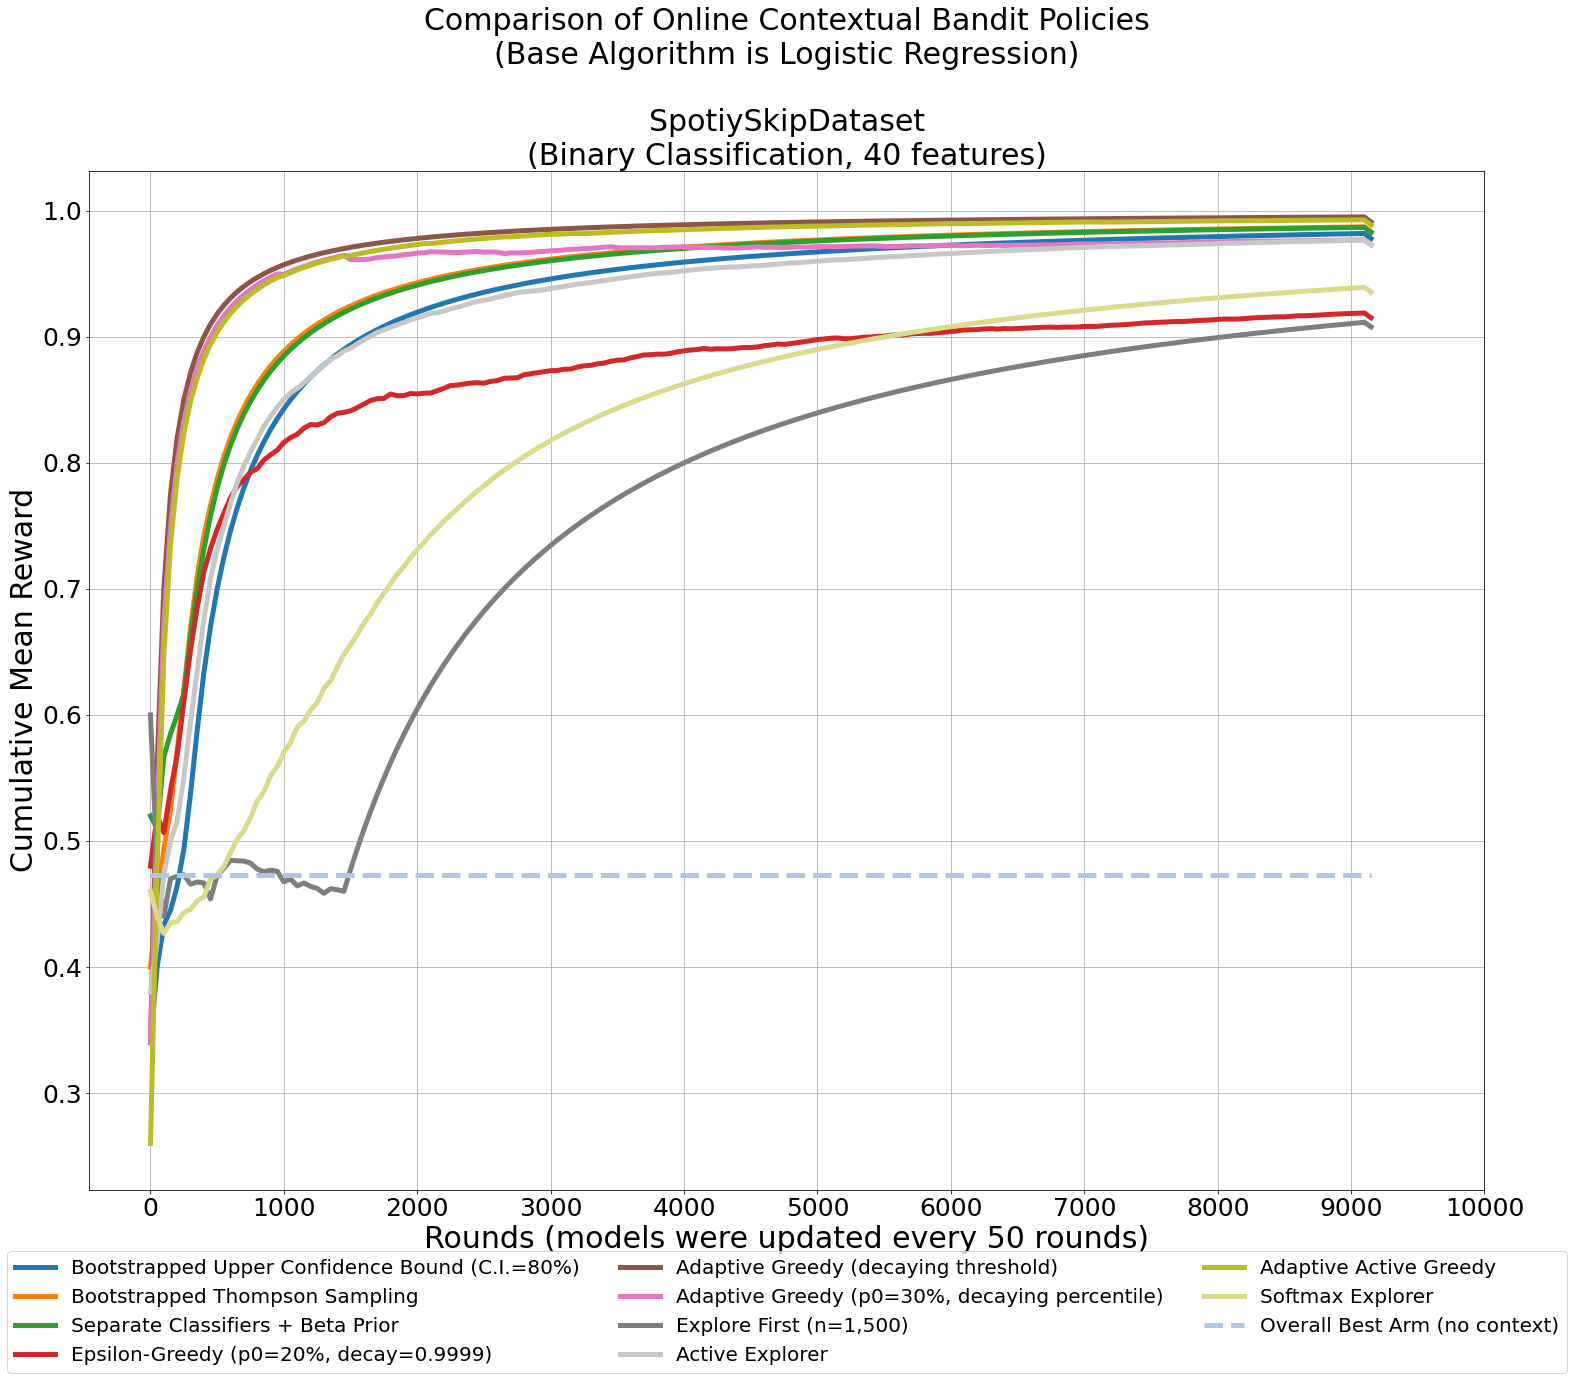

In [19]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
        mean_rew=list()
        for r in range(len(reward_lst)):
            mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
        return mean_rew
rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
#plt.plot(get_mean_reward(rewards_lucb), label=\"Logistic Upper Confidence Bound (C.I.=70%)\",linewidth=lwd,color=colors[8])\n",
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

# import warnings\n",
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(11)], [i*1000 for i in range(11)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nSpotiySkipDataset\n(Binary Classification, 40 features)',size=30)
plt.grid()
plt.show()